Copyright 2025 Joe Worsham

In [1]:
# obligatory reload content dynamically
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow_dynamics as tfd

In [3]:
import itertools
import math
import numpy as np
import tensorflow as tf

In [4]:
from collections import namedtuple
from matplotlib import pyplot as plt
from tqdm import tqdm

In [5]:
tf.keras.backend.set_floatx('float64')

# Nested n-Spheres Problem

The next n-Spheres problem is an aribitrary function that cannot be represented by a NODE. It is defined below.

In [6]:
r1 = 1.
r2 = 2.
r3 = 3.

gx_min1_polar = tf.random.uniform([1000, 2], minval=[0., 0.], maxval=[r1, 2*math.pi], dtype=tf.float64)
gx_1_polar = tf.random.uniform([1000, 2], minval=[r2, 0.], maxval=[r3, 2*math.pi], dtype=tf.float64)

gx_min1 = tf.stack([gx_min1_polar[..., 0] * tf.math.cos(gx_min1_polar[..., 1]),
                    gx_min1_polar[..., 0] * tf.math.sin(gx_min1_polar[..., 1])],
                   axis=-1)
gx_1 = tf.stack([gx_1_polar[..., 0] * tf.math.cos(gx_1_polar[..., 1]),
                 gx_1_polar[..., 0] * tf.math.sin(gx_1_polar[..., 1])],
                axis=-1)

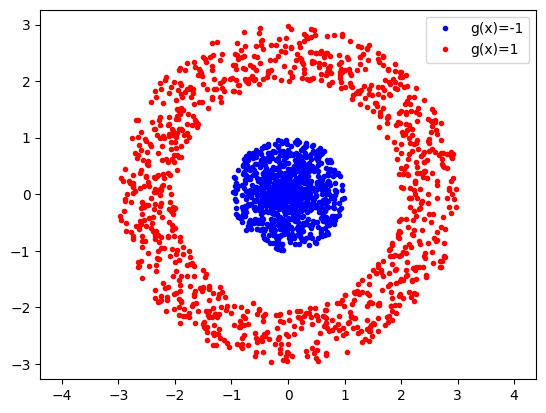

In [7]:
plt.plot(gx_min1[..., 0], gx_min1[..., 1], 'b.', label="g(x)=-1")
plt.plot(gx_1[..., 0], gx_1[..., 1], 'r.', label="g(x)=1")
plt.axis('equal')
plt.legend()
plt.show()

In [8]:
x = tf.concat([gx_min1, gx_1], axis=0)
y = tf.cast(tf.concat([[-1,]*1000, [1,]*1000], axis=0), dtype=tf.float64)

# Discover Latent Trajectories

In [58]:
class NodeClassifier(tf.keras.Model):
    def __init__(self, node):
        super().__init__()
        self._node = node
        self._linear_transform = tfd.models.layers.LinearTransform(1)
        
    def call(self, x):
        x = self._node(x)
        return self._linear_transform(x)

In [59]:
def run_experiment(dx_dt, encoder, decoder, method, options, use_adjoint, adjoint_options, epochs=200, lr=1e-3):
    # build the NODE to test
    t_0 = tf.zeros([1,], dtype=tf.float64)
    t_f = tf.ones([1,], dtype=tf.float64)
    #time_range = tf.linspace(t_0, t_f, 32)
    time_range = tf.stack([t_0, t_f], axis=0)
    time_range = tf.transpose(time_range, [1, 0])
    node = tfd.models.node.BaseNODE(dx_dt=dx_dt, encoder=encoder, decoder=decoder,
                                    t_eval=time_range,
                                    method=method, options=options, use_adjoint=use_adjoint,
                                    adjoint_options=adjoint_options)
    node = NodeClassifier(node)
    
    # touch to initialize weights
    y_hat = node(x)
    
    # train for specified epochs
    losses = []
    mse = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    for i in tqdm(range(epochs)):
        with tf.GradientTape() as tape:
            y_hat = node(x)
            y_f_hat = y_hat[:, -1, :]
            loss = mse(y, y_f_hat)
        grads = tape.gradient(loss, node.trainable_variables)
        optimizer.apply_gradients(zip(grads, node.trainable_variables))
        losses.append(loss)
        
    return node, losses

In [60]:
dp5_options = dict(rtol=1e-3, atol=1e-4)
rk4_options = dict(h=tf.constant(1/32, dtype=tf.float64))
dp5_adjoint_options = dict(rtol=1e-12, atol=1e-12)

## NODE Latent Trajectories

In [61]:
node = tfd.models.layers.AutonomousDxDtMLP(2)
encoder = None
decoder = None
model, losses = run_experiment(node, encoder, decoder,
                               "dopri5", dp5_options,
                               True, dp5_options,
                               epochs=200, lr=1e-3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [04:53<00:00,  1.47s/it]


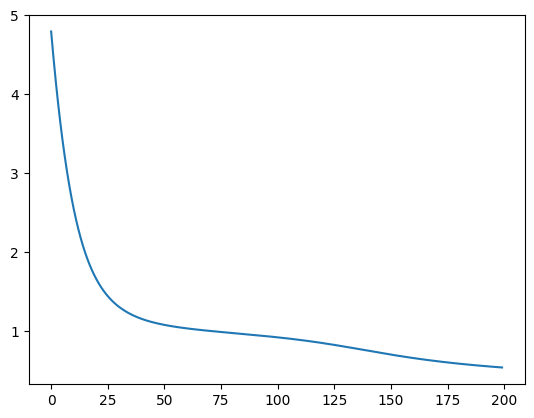

In [62]:
plt.plot(losses)

In [63]:
out_x = model._node(x)
out_x.shape

TensorShape([2000, 2, 2])

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\users\joewo\workspaces\tensorflow_dynamics\tensorflow_dynamics\de\solvers.py", line 76, in <genexpr>
    ys = tuple(ys_n.write(eval_idx, prev_yn) for ys_n, prev_yn in zip(ys, prev_y))  File "C:\Users\joewo\python_envs\tfd\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\users\joewo\workspaces\tensorflow_dynamics\tensorflow_dynamics\de\solvers.py", line 76, in <genexpr>
    ys = tuple(ys_n.write(eval_idx, prev_yn)

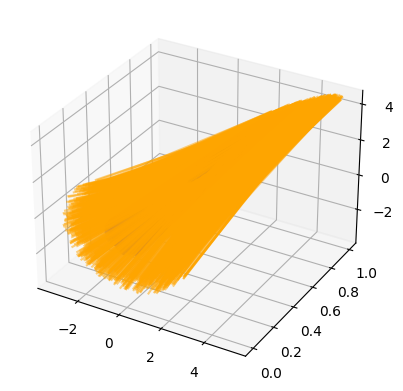

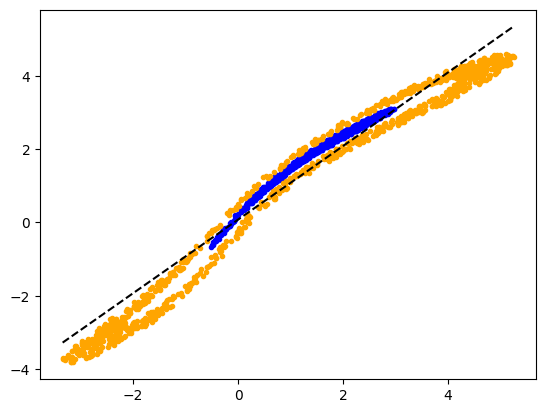

In [64]:
t_eval = np.linspace(0, 1, out_x.shape[1])
ax_3d = plt.figure().add_subplot(projection='3d')
ax_2d = plt.figure().add_subplot()
for i in range(2000):
    color = "blue" if y[i] < 0 else "orange"
    ax_3d.plot(out_x[i, :, 0], t_eval, out_x[i, :, 1], color=color, alpha=0.5)
    ax_2d.plot(out_x[i, -1, 0], out_x[i, -1, 1], '.', color=color)
    
# plot the dividing line
k = model._linear_transform._out_layer.kernel
b = model._linear_transform._out_layer.bias
x1n = tf.cast(tf.linspace(tf.reduce_min(out_x[:, -1, 0]), tf.reduce_max(out_x[:, -1, 0]), 100), dtype=tf.float64)
yn = (k[0, 0] / -k[1, 0]) * x1n + b[0]
ax_2d.plot(x1n, yn, 'k--')
plt.show()

## ANODE Latent Trajectories

In [65]:
anode = tfd.models.layers.AutonomousDxDtMLP(3)
encoder = tfd.models.layers.ZeroAugmenter(2, 1)
decoder = tfd.models.layers.Truncate(2)
model, losses = run_experiment(anode, encoder, decoder,
                               "rk4", rk4_options,
                               True, rk4_options,
                               epochs=200, lr=1e-3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [15:37<00:00,  4.69s/it]


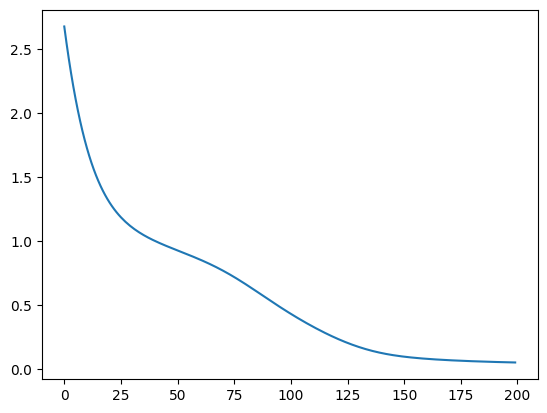

In [66]:
plt.plot(losses)

In [67]:
out_x = model._node(x)
out_x.shape

TensorShape([2000, 2, 2])

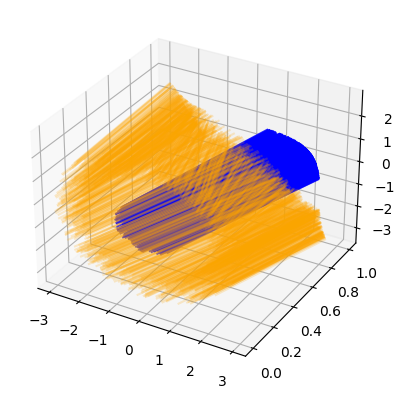

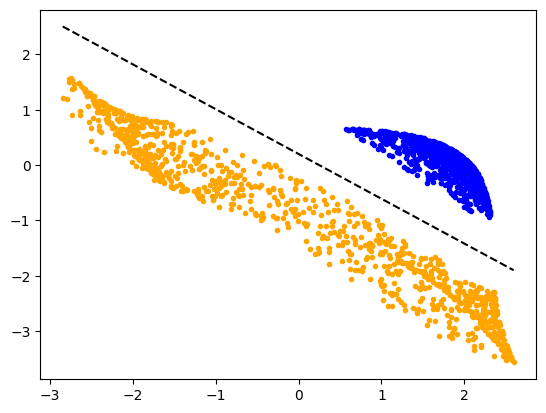

In [68]:
t_eval = np.linspace(0, 1, out_x.shape[1])
ax_3d = plt.figure().add_subplot(projection='3d')
ax_2d = plt.figure().add_subplot()
for i in range(2000):
    color = "blue" if y[i] < 0 else "orange"
    alpha = 0.8 if y[i] < 0 else 0.2
    ax_3d.plot(out_x[i, :, 0], t_eval, out_x[i, :, 1], color=color, alpha=alpha)
    ax_2d.plot(out_x[i, -1, 0], out_x[i, -1, 1], '.', color=color)
    
# plot the dividing line
k = model._linear_transform._out_layer.kernel
b = model._linear_transform._out_layer.bias
x1n = tf.cast(tf.linspace(tf.reduce_min(out_x[:, -1, 0]), tf.reduce_max(out_x[:, -1, 0]), 100), dtype=tf.float64)
yn = (k[0, 0] / -k[1, 0]) * x1n + b[0]
ax_2d.plot(x1n, yn, 'k--')
plt.show()

## SONODE Latent Trajectories

In [69]:
sonode = tfd.models.layers.Autonomous2ndOrderDxDtMLP(2)
encoder = tfd.models.layers.MLPAugmenter(2)
decoder = tfd.models.layers.Truncate(2)
model, losses = run_experiment(sonode, encoder, decoder,
                               "rk4", rk4_options,
                               True, rk4_options,
                               epochs=200, lr=1e-2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [19:11<00:00,  5.76s/it]


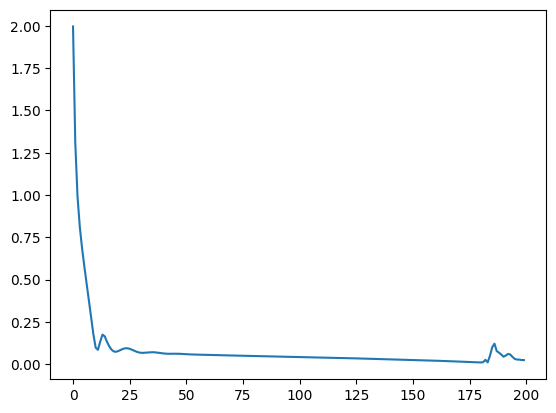

In [70]:
plt.plot(losses)

In [71]:
out_x = model._node(x)
out_x.shape

TensorShape([2000, 2, 2])

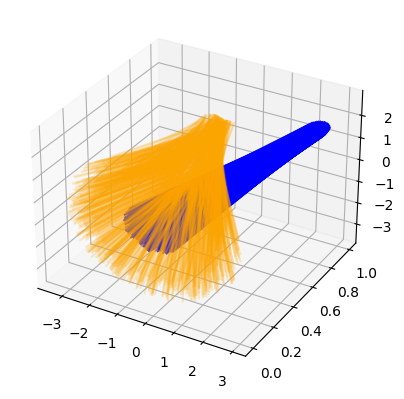

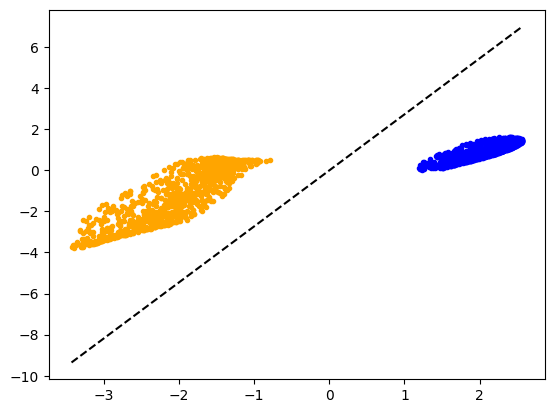

In [72]:
t_eval = np.linspace(0, 1, out_x.shape[1])
ax_3d = plt.figure().add_subplot(projection='3d')
ax_2d = plt.figure().add_subplot()
for i in range(2000):
    color = "blue" if y[i] < 0 else "orange"
    alpha = 0.8 if y[i] < 0 else 0.2
    ax_3d.plot(out_x[i, :, 0], t_eval, out_x[i, :, 1], color=color, alpha=alpha)
    ax_2d.plot(out_x[i, -1, 0], out_x[i, -1, 1], '.', color=color)
    
# plot the dividing line
k = model._linear_transform._out_layer.kernel
b = model._linear_transform._out_layer.bias
x1n = tf.cast(tf.linspace(tf.reduce_min(out_x[:, -1, 0]), tf.reduce_max(out_x[:, -1, 0]), 100), dtype=tf.float64)
yn = (k[0, 0] / -k[1, 0]) * x1n + b[0]
ax_2d.plot(x1n, yn, 'k--')
plt.show()